In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import shap
import pandas as pd
import os
import src.utils as utils
import src.classifier as clf
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from src.preprocess import TextCleaner
from src.preprocess import ColumnSelector
from src.preprocess import TypeSelector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

In [2]:
path = os.getcwd()
labels = pd.read_table(path + '/resources/data/corpus_machismo_etiquetas.csv', sep=";")
labels = labels[["status_id","categoria"]]
tweets_fields = pd.read_csv(path + '/resources/data/corpus_machismo_frodriguez_atributos_extra.csv', 
                            dtype={'status_id': 'str'})
tweets_fields.head()

,filename,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,termino
0,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,154970429,1013567568039366661,2018-07-01 23:38:34,valunaticx,hoy a la mañana me quisieron levantar a un aut...,Twitter for Android,106,NaN,NaN,...,10537,2010-06-12 18:54:29,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/15497042...,http://abs.twimg.com/images/themes/theme10/bg.gif,http://pbs.twimg.com/profile_images/1010928341...,feminazi
1,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,996795854123134977,1013555580680667136,2018-07-01 22:50:56,MillaZapata,@funesmemoriosa @Leaobutron Lo que pasa es que...,Twitter for Android,86,1.013498e+18,50198488.0,...,1326,2018-05-16 16:53:46,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/99679585...,NaN,http://pbs.twimg.com/profile_images/9967992596...,feminazi
2,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,577431222,1013556044096733184,2018-07-01 22:52:46,beluluque1,Anoche a la salida del boliche dos chicos tira...,Twitter for iPhone,276,NaN,NaN,...,2949,2012-05-11 18:14:59,False,NaN,NaN,en,https://pbs.twimg.com/profile_banners/57743122...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9516401268...,feminazi
3,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,87143378,1013492312205398017,2018-07-01 18:39:31,rubinho_152,@tjcope y va la tonta y pregunta por la prensa...,Twitter Lite,81,NaN,182330628.0,...,6,2009-11-03 08:33:03,False,NaN,NaN,en,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/sticky/default_profile_im...,"""a fregar"""
4,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,870191034311069697,1013430666539790336,2018-07-01 14:34:34,killwthlove,"Que no me cuentes tu vida, niñata. https://t.c...",Twitter for Android,34,NaN,NaN,...,1258,2017-06-01 08:11:24,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/87019103...,NaN,http://pbs.twimg.com/profile_images/1012329454...,ninata


In [3]:
x_cols2 = ['text','source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified', 'categoria']
tweets_fields = utils.change_dtypes(tweets_fields, {'status_id': str})
labels = utils.change_dtypes(labels, {'status_id': str})
tweets_labeled = tweets_fields.merge(labels, on = 'status_id', how = 'inner')
tweets_labeled['respuesta'] = np.where(tweets_labeled['reply_to_status_id'].isnull(), 'no', 'si')
tweets_labeled['respuesta_screen_name'] = np.where(tweets_labeled['reply_to_screen_name'].isnull(), 'no', 'si') 
tweets_labeled['hastag_presence'] = np.where(tweets_labeled['hashtags'].isnull(), 'no', 'si') 
tweets_labeled['url_presence'] = np.where(tweets_labeled['urls_url'].isnull(), 'no', 'si') 
tweets_labeled['mentions_presence'] = np.where(tweets_labeled['mentions_user_id'].isnull(), 'no', 'si') 
dudosos_dict = {"DUDOSO": "MACHISTA"}
#tweets_labeled = tweets_labeled.replace({"categoria" :dudosos_dict})
#tweets_labeled = utils.downsample(tweets_labeled, 'NO_MACHISTA', 267)
#tweets_labeled = utils.downsample(tweets_labeled, 'MACHISTA', 267)
#tweets_labeled = tweets_labeled.loc[80:100,:]
#tweets_labeled = tweets_labeled.loc[0:100,:]
tweets_labeled.head()
categorical_features = ['source', 'respuesta', 'respuesta_screen_name',
          'hastag_presence', 'url_presence',
          'media_type', 'mentions_presence', 'verified']
for f in categorical_features:
    tweets_labeled[f] = tweets_labeled[f].astype("category")

In [4]:
x_cols = ['source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified']
classifier = 'logistic_regression'
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(strategy="constant"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="constant", fill_value = "NA"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)
        
preprocessor = TextCleaner(filter_users=True, filter_hashtags=True, 
                           filter_urls=True, convert_hastags=True, lowercase=True, 
                           replace_exclamation=True, replace_interrogation=True, 
                           remove_accents=True, remove_punctuation=True, replace_emojis=True)   
     
text_pipeline = Pipeline([
    ('column_selection', ColumnSelector('text')),
    ('tfidf', TfidfVectorizer(tokenizer=utils.tokenizer_, 
                                          smooth_idf=True, preprocessor = preprocessor,
                                          norm=None, min_df=0.01, ngram_range=(1,1)))
])  
    
union_pipeline = Pipeline([('feature-union', FeatureUnion([('text-features', text_pipeline), 
                               ('other-features', preprocess_pipeline)
                              ]))
                          ])

In [5]:
classifier_pipeline = Pipeline([('feature-union', FeatureUnion([('text-features', text_pipeline), 
                               ('other-features', preprocess_pipeline)
                              ])),
                          ('clf', clf.get_classifier(classifier))
                          ])

In [6]:
parameters = utils.get_grid_parameters(classifier)
model = GridSearchCV(classifier_pipeline, param_grid=parameters, cv=5,
                         scoring='f1_macro', verbose=1, n_jobs = -1)

tweets_labeled2 = tweets_labeled.sample(frac=1).reset_index(drop=True)
final_evaluation_size = tweets_labeled2.shape[0]*0.7
#tweets_labeled2.loc[:final_evaluation_size,:]
final_evaluation = tweets_labeled2.loc[:final_evaluation_size-1,:]
train = tweets_labeled2.loc[final_evaluation_size:,:]
model.fit(train[x_cols2], train['categoria'])
#model.best_estimator_


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feature-union', FeatureUnion(n_jobs=None,
       transformer_list=[('text-features', Pipeline(memory=None,
     steps=[('column_selection', ColumnSelector(columns='text')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.float64'>...nalty='l2', random_state=123,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__C': [1, 10], 'clf__class_weight': [None, 'balanced'], 'clf__multi_class': ['ovr', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [7]:
#tweets_labeled2.head()
#train.shape
#final_evaluation.shape


In [8]:
dataset_tfidf = union_pipeline.fit_transform(final_evaluation[x_cols2]).todense()
numeric = final_evaluation[x_cols2].select_dtypes(include=np.number).columns.tolist()
categorical = preprocess_pipeline.steps[1][1].transformer_list[1][1].steps[2][1].get_feature_names().tolist()
columns = text_pipeline.named_steps['tfidf'].get_feature_names() + numeric + categorical
df = pd.DataFrame(dataset_tfidf, columns = columns)

In [9]:
#df.to_csv("tfidf.csv")

In [10]:
final_evaluation[x_cols2].shape

(2520, 18)

In [11]:
df.head()

,2,adema,ahora,alguien,amiga,anda,ano,aqui,asi,bien,...,x3_no,x3_si,x4_no,x4_si,x5_NA,x5_photo,x6_no,x6_si,x7_False,x7_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.256808,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.795458,3.628404,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [12]:
model.best_params_

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__multi_class': 'ovr'}

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#num_dict = {"DUDOSO": 3, "MACHISTA": 1, "NO_MACHISTA" : 2}
#tweets_labeled = tweets_labeled.replace({"categoria" :num_dict})
X_train, X_test, y_train, y_test = train_test_split(df, final_evaluation['categoria'], test_size=0.1, random_state=7)
classifier = LogisticRegression(C=1, class_weight=None, multi_class='ovr')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
#y_pred


In [14]:
X_test.head()
predicciones = X_test
predicciones = predicciones.assign(y_pred = pd.Series(y_pred).values, y_real = pd.Series(y_test).values)
predicciones.head()
#predicciones.to_csv("predicciones.csv")
#tweets_labeled[x_cols2].to_csv("texto_predicciones.csv")

,2,adema,ahora,alguien,amiga,anda,ano,aqui,asi,bien,...,x4_no,x4_si,x5_NA,x5_photo,x6_no,x6_si,x7_False,x7_True,y_pred,y_real
2248,0.0,0.0,0.0,0.0,0.0,0.0,8.827141,0.0,0.0,0.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,NO_MACHISTA,NO_MACHISTA
933,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3.628404,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NO_MACHISTA,NO_MACHISTA
412,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,MACHISTA,MACHISTA
213,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NO_MACHISTA,NO_MACHISTA
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,DUDOSO,DUDOSO


In [27]:
#predicciones.to_csv("predicciones2.csv")

In [15]:
classifier.classes_

array(['DUDOSO', 'MACHISTA', 'NO_MACHISTA'], dtype=object)

In [16]:
#explainer = shap.KernelExplainer(classifier.predict_proba, X_train)
explainer = shap.LinearExplainer(classifier, X_train)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)
#tweets_labeled['categoria']

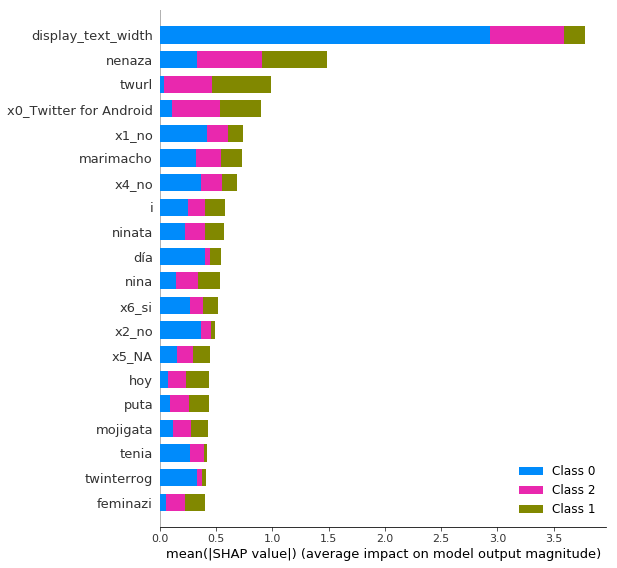

In [17]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


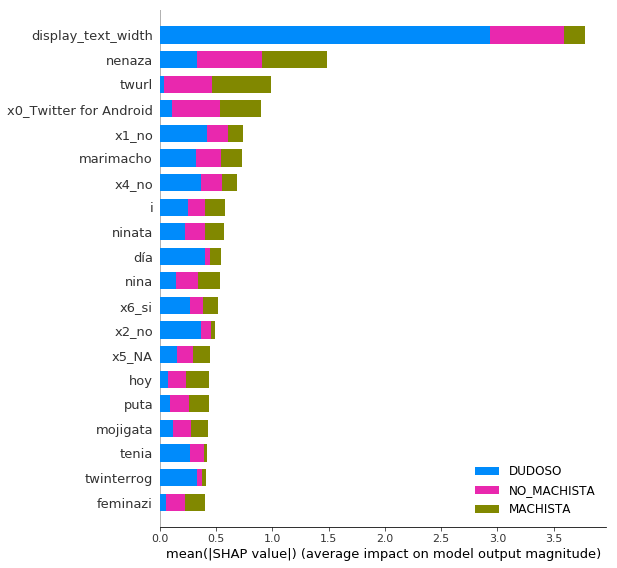

In [18]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names = classifier.classes_)

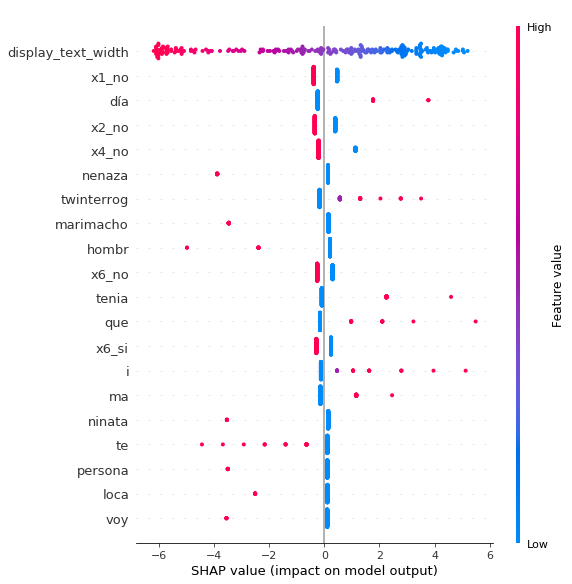

In [19]:
#DUDOSO
shap.summary_plot(shap_values[0], X_test)


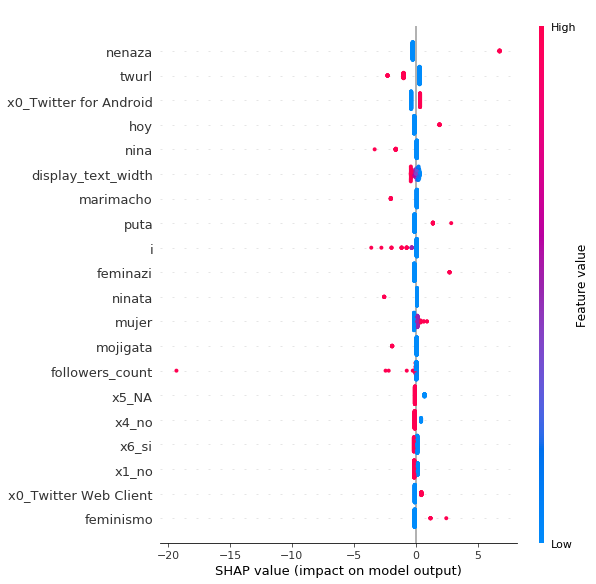

In [20]:
#MACHISTA
shap.summary_plot(shap_values[1], X_test)


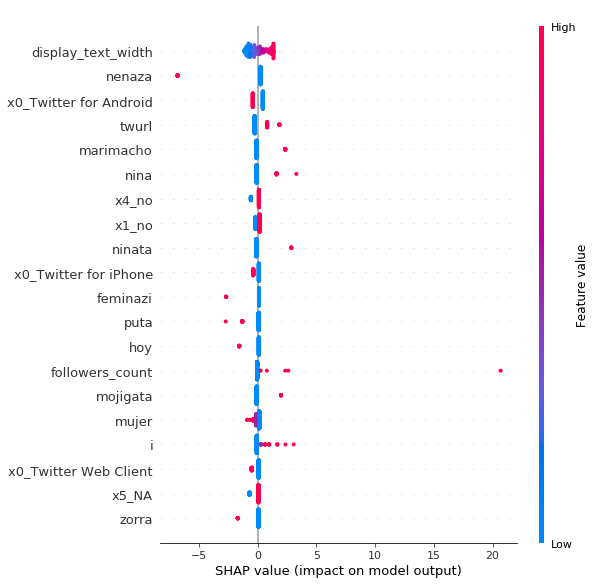

In [21]:
#NO MACHISTA
shap.summary_plot(shap_values[2], X_test)


In [40]:
tweets_labeled2.iloc[2282]['text']

'Escuchando al beb\xc3\xa9 malcriado y por supuesto imb\xc3\xa9cil de Rufi\xc3\xa1n quejarse porque le llaman imb\xc3\xa9cil cuando \xc3\xa9l llama palmera a una pol\xc3\xadtica. Por cierto, luego habr\xc3\xa1 mucho 8-M, mucho feminismo, pero no la han defendido las mujeres de la sala. Sin duda mucho imb\xc3\xa9cil y mucha imb\xc3\xa9cil'

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][8,:], X_test.iloc[8,:])


In [41]:
X_test.iloc[8]

2                             0.0
adema                         0.0
ahora                         0.0
alguien                       0.0
amiga                         0.0
anda                          0.0
ano                           0.0
aqui                          0.0
asi                           0.0
bien                          0.0
buena                         0.0
bueno                         0.0
cada                          0.0
call                          0.0
cara                          0.0
casa                          0.0
chico                         0.0
cocina                        0.0
comentario                    0.0
cono                          0.0
constant                      0.0
cosa                          0.0
creo                          0.0
cuenta                        0.0
cuerpo                        0.0
dar                           0.0
de                            0.0
deberian                      0.0
decir                         0.0
deja          